# 作業詳解

1. conda create -n aicg python=3.10
2. conda activate aicg
3. pip install -r requirements.txt

4. conda activate aicg
5. jupyter lab

In [1]:
import os
import json

In [2]:
os.chdir("../../../")

In [4]:
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate, SystemMessagePromptTemplate
from langchain.output_parsers import StructuredOutputParser, ResponseSchema

from src.initialization import credential_init
from src.io.path_definition import get_project_dir


credential_init()

model = ChatOpenAI(openai_api_key=os.environ['OPENAI_API_KEY'],
                   model_name="gpt-4o-mini", temperature=0)

with open(os.path.join(get_project_dir(), 'tutorial', 'LLM+Langchain', 
                       'Week-1', 'recipe_train.json'), 'r') as f:
    recipe_train = json.load(f)

In [ ]:
recipe_train[100]

In [5]:
from langchain_community.retrievers import BM25Retriever
from langchain.docstore.document import Document

documents = []

for recipe in recipe_train:
    document = Document(page_content=", ".join(recipe['ingredients']),
                        metadata={"cuisine": recipe['cuisine'],
                                  "id": recipe['id']})
    documents.append(document)

bm25_retriever = BM25Retriever.from_documents(documents, k=10, bm25_params={"k1":2.5})

In [6]:
# I created this last week after the session
def build_standard_chat_prompt_template(kwargs):

    system_content = kwargs['system']
    human_content = kwargs['human']
    
    system_prompt = PromptTemplate(**system_content)
    system_message = SystemMessagePromptTemplate(prompt=system_prompt)
    
    human_prompt = PromptTemplate(**human_content)
    human_message = HumanMessagePromptTemplate(prompt=human_prompt)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message,
                                                     human_message
                                                   ])

    return chat_prompt

In [16]:
from textwrap import dedent


response_schemas = [
        ResponseSchema(name="used ingredients", 
                       description="The actual ingredients used in cooking"),
        ResponseSchema(name="extra ingredients", 
                       description="extra ingredients that have to be prepared"),
        ResponseSchema(name="result", 
                       description="The dish and cooking recipe in detail")
    ]
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

format_instructions = output_parser.get_format_instructions()

system_template = dedent("""
                  You are an AI assistant as the best chef in the world. 
                  You have a great taste and cooking skills like Gordon Ramsay. 
                  You should be able to come up with a dish based on `suggested ingredient`, 
                  and tell us what extra ingredients has to be prepared by comparing 
                  the ingredients actually used in the cooking and the `existing ingredient`.

                  The `suggested ingredients` are the ingredients suggested 
                  by some recipe. You have the freedom to add or remove 
                  ingredients to achieve the goal, but try to be as faithful 
                  to the `suggested ingredient` as possible. 
                  """)

human_template = dedent("""
                 existing ingredients:[{existing_ingredients}];
                 suggested ingredients: [{suggested_ingredients}]\n; 
                 format instruction: {format_instructions}
                 """)


input_ = {"system": {"template": system_template},
          "human": {"template": human_template,
                    "input_variable": ["existing_ingredients", "suggested_ingredients"],
                    "partial_variables": {"format_instructions": format_instructions}}}

my_chat_prompt_template = build_standard_chat_prompt_template(input_)

In [7]:
# Because I am lazy so I use data from another dataset.

with open(os.path.join(get_project_dir(), 'tutorial', 'LLM+Langchain', 'Week-1', 'recipe_test.json'), 'r') as f:
    recipe_test = json.load(f)

# What you have in your fridge
existing_ingredients = ", ".join(recipe_test[0]['ingredients'])

print(f"existing_ingredients: {existing_ingredients}")

output = bm25_retriever.invoke(existing_ingredients)

existing_ingredients: olive oil, balsamic vinegar, toasted pine nuts, kosher salt, golden raisins, part-skim ricotta cheese, grated parmesan cheese, baby spinach, fresh basil leaves, pepper, fusilli, scallions


In [8]:
output[0]

Document(metadata={'cuisine': 'italian', 'id': 7983}, page_content='Italian parsley leaves, toasted pine nuts, olive oil, fresh oregano, fresh leav spinach, salt, fresh basil leaves, grated parmesan cheese, garlic cloves')

In [9]:
suggested_ingredients = output[0].page_content

In [10]:
suggested_ingredients

'Italian parsley leaves, toasted pine nuts, olive oil, fresh oregano, fresh leav spinach, salt, fresh basil leaves, grated parmesan cheese, garlic cloves'

### Validation

Let us learn some python....

In [12]:
existing_ingredients_as_list = recipe_test[0]['ingredients']
suggested_ingredients_as_list = suggested_ingredients.split(", ")

In [13]:
for suggested_ingredient in suggested_ingredients_as_list:
    if suggested_ingredient in existing_ingredients_as_list:
        print(f"- {suggested_ingredient}: yes")
    else:
        print(f"- {suggested_ingredient}: no")

- Italian parsley leaves: no
- toasted pine nuts: yes
- olive oil: yes
- fresh oregano: no
- fresh leav spinach: no
- salt: no
- fresh basil leaves: yes
- grated parmesan cheese: yes
- garlic cloves: no


In [17]:
prompt = my_chat_prompt_template.invoke(
    {"existing_ingredients": existing_ingredients, 
     "suggested_ingredients": suggested_ingredients})

In [19]:
my_chat_prompt_template

ChatPromptTemplate(input_variables=['existing_ingredients', 'suggested_ingredients'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='\nYou are an AI assistant as the best chef in the world. \nYou have a great taste and cooking skills like Gordon Ramsay. \nYou should be able to come up with a dish based on `suggested ingredient`, \nand tell us what extra ingredients has to be prepared by comparing \nthe ingredients actually used in the cooking and the `existing ingredient`.\n\nThe `suggested ingredients` are the ingredients suggested \nby some recipe. You have the freedom to add or remove \ningredients to achieve the goal, but try to be as faithful \nto the `suggested ingredient` as possible. \n'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['existing_ingredients', 'suggested_ingredients'], input_types={}, partial_variables={

In [18]:
prompt

ChatPromptValue(messages=[SystemMessage(content='\nYou are an AI assistant as the best chef in the world. \nYou have a great taste and cooking skills like Gordon Ramsay. \nYou should be able to come up with a dish based on `suggested ingredient`, \nand tell us what extra ingredients has to be prepared by comparing \nthe ingredients actually used in the cooking and the `existing ingredient`.\n\nThe `suggested ingredients` are the ingredients suggested \nby some recipe. You have the freedom to add or remove \ningredients to achieve the goal, but try to be as faithful \nto the `suggested ingredient` as possible. \n', additional_kwargs={}, response_metadata={}), HumanMessage(content='\n                 existing ingredients:[olive oil, balsamic vinegar, toasted pine nuts, kosher salt, golden raisins, part-skim ricotta cheese, grated parmesan cheese, baby spinach, fresh basil leaves, pepper, fusilli, scallions];\n                 suggested ingredients: [Italian parsley leaves, toasted pine n

In [20]:
output = model.invoke(prompt)
print(output.content)

```json
{
	"used ingredients": "olive oil, toasted pine nuts, kosher salt, golden raisins, part-skim ricotta cheese, grated parmesan cheese, baby spinach, fresh basil leaves, pepper, fusilli, scallions, garlic cloves, fresh oregano, Italian parsley leaves",
	"extra ingredients": "fresh oregano, Italian parsley leaves, garlic cloves",
	"result": "### Spinach and Ricotta Fusilli with Pine Nuts and Herbs\n\n#### Ingredients:\n- 2 cups fusilli pasta\n- 2 tablespoons olive oil\n- 2 cloves garlic, minced\n- 1 cup baby spinach, chopped\n- 1 cup part-skim ricotta cheese\n- 1/2 cup grated parmesan cheese\n- 1/4 cup toasted pine nuts\n- 1/4 cup golden raisins\n- 1/4 cup scallions, chopped\n- 1/4 cup fresh basil leaves, chopped\n- 1/4 cup Italian parsley leaves, chopped\n- 1 teaspoon fresh oregano, chopped\n- Kosher salt and pepper to taste\n\n#### Instructions:\n1. **Cook the Pasta:** In a large pot of salted boiling water, cook the fusilli according to package instructions until al dente. Drain

In [21]:
final_output = output_parser.parse(output.content)
print(final_output)

{'used ingredients': 'olive oil, toasted pine nuts, kosher salt, golden raisins, part-skim ricotta cheese, grated parmesan cheese, baby spinach, fresh basil leaves, pepper, fusilli, scallions, garlic cloves, fresh oregano, Italian parsley leaves', 'extra ingredients': 'fresh oregano, Italian parsley leaves, garlic cloves', 'result': '### Spinach and Ricotta Fusilli with Pine Nuts and Herbs\n\n#### Ingredients:\n- 2 cups fusilli pasta\n- 2 tablespoons olive oil\n- 2 cloves garlic, minced\n- 1 cup baby spinach, chopped\n- 1 cup part-skim ricotta cheese\n- 1/2 cup grated parmesan cheese\n- 1/4 cup toasted pine nuts\n- 1/4 cup golden raisins\n- 1/4 cup scallions, chopped\n- 1/4 cup fresh basil leaves, chopped\n- 1/4 cup Italian parsley leaves, chopped\n- 1 teaspoon fresh oregano, chopped\n- Kosher salt and pepper to taste\n\n#### Instructions:\n1. **Cook the Pasta:** In a large pot of salted boiling water, cook the fusilli according to package instructions until al dente. Drain and set asi

In [ ]:
final_output.keys()

In [22]:
print(final_output['used ingredients'])

olive oil, toasted pine nuts, kosher salt, golden raisins, part-skim ricotta cheese, grated parmesan cheese, baby spinach, fresh basil leaves, pepper, fusilli, scallions, garlic cloves, fresh oregano, Italian parsley leaves


In [23]:
print(final_output['extra ingredients'])

fresh oregano, Italian parsley leaves, garlic cloves


In [24]:
print(final_output['result'])

### Spinach and Ricotta Fusilli with Pine Nuts and Herbs

#### Ingredients:
- 2 cups fusilli pasta
- 2 tablespoons olive oil
- 2 cloves garlic, minced
- 1 cup baby spinach, chopped
- 1 cup part-skim ricotta cheese
- 1/2 cup grated parmesan cheese
- 1/4 cup toasted pine nuts
- 1/4 cup golden raisins
- 1/4 cup scallions, chopped
- 1/4 cup fresh basil leaves, chopped
- 1/4 cup Italian parsley leaves, chopped
- 1 teaspoon fresh oregano, chopped
- Kosher salt and pepper to taste

#### Instructions:
1. **Cook the Pasta:** In a large pot of salted boiling water, cook the fusilli according to package instructions until al dente. Drain and set aside.

2. **Sauté Garlic:** In a large skillet, heat the olive oil over medium heat. Add the minced garlic and sauté for about 1 minute until fragrant.

3. **Add Spinach:** Add the chopped baby spinach to the skillet and cook until wilted, about 2-3 minutes.

4. **Combine Ingredients:** In the skillet, add the cooked fusilli, ricotta cheese, grated parme

In [25]:
translated_result = model.invoke(f"Translate the content into traditional Chinese (繁體中文): {final_output['result']}")

In [26]:
print(translated_result.content)

### 菠菜和瑞可達起司螺旋麵配松子和香草

#### 材料：
- 2杯螺旋麵
- 2湯匙橄欖油
- 2瓣大蒜，切碎
- 1杯嬰兒菠菜，切碎
- 1杯部分脫脂瑞可達起司
- 1/2杯磨碎的帕爾馬乾酪
- 1/4杯烤松子
- 1/4杯金葡萄乾
- 1/4杯青蔥，切碎
- 1/4杯新鮮羅勒葉，切碎
- 1/4杯意大利香菜葉，切碎
- 1茶匙新鮮牛至，切碎
- 猶太鹽和黑胡椒，適量

#### 做法：
1. **煮麵條：** 在一大鍋加鹽的滾水中，根據包裝說明煮螺旋麵至剛好熟透（al dente）。瀝乾並放在一旁。

2. **炒大蒜：** 在一個大平底鍋中，用中火加熱橄欖油。加入切碎的大蒜，炒約1分鐘，直到散發香味。

3. **加入菠菜：** 將切碎的嬰兒菠菜加入平底鍋中，煮至萎縮，約2-3分鐘。

4. **混合材料：** 在平底鍋中，加入煮好的螺旋麵、瑞可達起司、磨碎的帕爾馬乾酪、烤松子、金葡萄乾、青蔥、新鮮羅勒、意大利香菜和新鮮牛至。將所有材料拌勻。

5. **調味：** 根據口味加入猶太鹽和黑胡椒。如果混合物看起來乾，可以加入少許麵水或更多橄欖油。

6. **上菜：** 溫熱食用，若需要可用額外的帕爾馬乾酪和新鮮香草裝飾。享受美味的菠菜和瑞可達起司螺旋麵！


# Semantic based retrieval

Semantic-based retrieval is a method of finding information that focuses on understanding the meaning behind the words you use. Instead of just matching exact words, it looks for the context and concepts in your query. Here's a simple way to understand it:

- 1. Meaning Over Words: Imagine you want to find information about "healthy eating". Traditional search might look for documents with the exact phrase "healthy eating". Semantic-based retrieval, however, understands that terms like "nutritious diet" or "balanced diet" are related and will include those in the results.

- 2. Context Awareness: This method takes into account the context in which words are used. For example, if you search for "apple", a traditional search might give you results about the fruit and the tech company. Semantic-based retrieval uses context to determine whether you’re likely asking about a fruit or a tech product.

- 3. Natural Language Understanding: It works more like how humans understand language. When you ask a question, it tries to grasp the intent behind your query and finds relevant information accordingly.

- 4. Better Results: By focusing on the meaning and context, semantic-based retrieval can provide more accurate and relevant results. This means you spend less time sifting through unrelated information.


語義檢索是一種尋找信息的方法，它重點在於理解你使用的詞語背後的意思。與其僅僅匹配精確的詞語，它會尋找你查詢中的上下文和概念。以下是一種簡單的理解方式：

- 1. 重點在於意思：想像一下你想找關於“健康飲食”的信息。傳統搜索可能會尋找包含“健康飲食”這個精確詞語的文檔。而語義檢索則會理解“營養均衡的飲食”或“均衡飲食”等相關詞語，並將它們包含在結果中。

- 2. 上下文感知：這種方法會考慮詞語使用的上下文。例如，如果你搜索“蘋果”，傳統搜索可能會給你關於水果和科技公司的結果。語義檢索則會使用上下文來判斷你更可能是在詢問水果還是科技產品。

- 3. 自然語言理解：它更像人類理解語言的方式。當你提出問題時，它會嘗試理解你查詢背後的意圖，並相應地找到相關信息。

- 4. 更好的結果：通過重點關注意思和上下文，語義檢索可以提供更準確和相關的結果。這意味著你可以減少篩選無關信息的時間。

In [ ]:
'egg' == 'eggs'

In [27]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

# https://platform.openai.com/docs/guides/embeddings/what-are-embeddings

# A list of embedding models you can choose 
# https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

### 1. Creating Embeddings (創建嵌入):

- HuggingFaceEmbeddings is used to create embeddings (vector representations) for text data.
- The model all-MiniLM-L6-v2 from HuggingFace is specified to generate these embeddings. This model converts text into numerical vectors that capture the semantic meaning of the text.

- 使用 HuggingFaceEmbeddings 創建文本數據的嵌入（向量表示）。
- 指定 HuggingFace 的模型 all-MiniLM-L6-v2 來生成這些嵌入。此模型將文本轉換為數字向量，這些向量捕捉文本的語義。

In [ ]:
HuggingFaceEmbeddings?

In [28]:
embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

C:\Users\MengChieh\AppData\Local\Temp\ipykernel_12148\1019514392.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
C:\Users\MengChieh\miniconda3\envs\aicg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Loading a vectorstore:

A PDF file is processed and the content is saved as vectorstore. I will show you how in Week-5.

In [ ]:
for recipe in recipe_train:
    document = Document(page_content=", ".join(recipe['ingredients']),
                        metadata={"cuisine": recipe['cuisine'],
                                  "id": recipe['id']})
    documents.append(document)

bm25_retriever = BM25Retriever.from_documents(documents, k=10, bm25_params={"k1":2.5})

["text1", "text2", "text3", '']

documents = []

for a in data:
    documents.append(Document(page_content=a,
                             metadata={'category': } ))

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

vectorstore = FAISS.from_documents(documents, embedding=embeddings)

vectorstore.save_local("faiss_index")

vectorstore_1 = FAISS.load_local(
    "faiss_index", embeddings, allow_dangerous_deserialization=True
)

vectorstore_1.merge_from(vectorstore_2)

retriever = vectorstore.as_retriever(search_kwargs={'k': 5})

retriever.invoke("")

In [29]:
# embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

path = os.path.join(get_project_dir(), 'tutorial', 'LLM+Langchain', 'Week-2', 'BertV2 Index')

vectorstore = FAISS.load_local(path, embedding, allow_dangerous_deserialization=True)

### 3. Creating a Retriever (創建檢索器):

- The as_retriever method is called on the vectorstore object to create a retriever.
- This retriever is configured to use "similarity" as the search type, meaning it will find documents that are similar to a given query based on their vector embeddings.

- 在 vectorstore 對象上調用 as_retriever 方法來創建一個檢索器。
- 這個檢索器配置為使用“相似性”作為搜索類型，這意味著它將根據文檔的向量嵌入找到與給定查詢相似的文檔。

### 4. Setting Search Parameters (設置搜索參數):

- The search_kwargs argument is used to pass additional parameters to the search function.
- In this case, {'k': 5} is specified, which means the retriever will return the top 5 most similar documents for each query.

- 使用 search_kwargs 參數來傳遞額外的搜索功能參數。
- 在這裡，指定了 {'k': 5}，這意味著檢索器將返回每個查詢最相似的前 5 個文檔。

In [30]:
retriever = vectorstore.as_retriever(search_type="similarity", 
                                     search_kwargs={"k": 5})

In [31]:
retriever.invoke("What kind of attention does BERT use?")

[Document(page_content='Yukun Zhu, Ryan Kiros, Rich Zemel, Ruslan Salakhut- dinov, Raquel Urtasun, Antonio Torralba, and Sanja Fidler. 2015. Aligning books and movies: Towards story-like visual explanations by watching movies and reading books. In Proceedings of the IEEE international conference on computer vision, pages 19-27.\n\nAppendix for “BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding”\n\nWe organize the appendix into three sections:\n\n¢ Additional implementation details for BERT are presented in Appendix A;\n\n¢ Additional details for our experiments are presented in Appendix B; and\n\n¢ Additional ablation studies are presented in Appendix C.\n\nWe present additional ablation studies for BERT including:', metadata={'type': 'text', 'filename': 'bertv2.pdf'}),
 Document(page_content='BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art re- sults on eleven natural language processing tasks, including pushing the G

In [32]:
retriever.invoke("Is it difficult to fine-tune BERT?")

[Document(page_content='BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art re- sults on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQUAD v1.1 question answer- ing Test Fl to 93.2 (1.5 point absolute im- provement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement).', metadata={'type': 'text', 'filename': 'bertv2.pdf'}),
 Document(page_content='3.2. Fine-tuning BERT\n\nFine-tuning is straightforward since the self- attention mechanism in the Transformer al- lows BERT to model many downstream tasks— whether they involve single text or text pairs—by swapping out the appropriate inputs and outputs. For applications involving text pairs, a common pattern is to independently encode text pairs be- fore applying bidirectional cross attention, such as Parikh et al. (2016); Seo et al. (2017). BERT instead uses the self

## Runtime Configuration

What we learned last week: Runtime Configuration.

In [33]:
from langchain_core.runnables import ConfigurableField

query = "Is it difficult to fine-tune BERT?"

retriever = vectorstore.as_retriever(search_type="similarity").configurable_fields( \
                                        search_kwargs=ConfigurableField(
                                                id="hello_search",
                                            )
                                        )

In [34]:
retriever.invoke(query, config={"configurable": {"hello_search": {"k": 7}}})

[Document(page_content='BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art re- sults on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQUAD v1.1 question answer- ing Test Fl to 93.2 (1.5 point absolute im- provement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement).', metadata={'type': 'text', 'filename': 'bertv2.pdf'}),
 Document(page_content='3.2. Fine-tuning BERT\n\nFine-tuning is straightforward since the self- attention mechanism in the Transformer al- lows BERT to model many downstream tasks— whether they involve single text or text pairs—by swapping out the appropriate inputs and outputs. For applications involving text pairs, a common pattern is to independently encode text pairs be- fore applying bidirectional cross attention, such as Parikh et al. (2016); Seo et al. (2017). BERT instead uses the self

In [35]:
retriever.invoke(query, config={"configurable": {"hello_search": {"k": 3}}})

[Document(page_content='BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art re- sults on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQUAD v1.1 question answer- ing Test Fl to 93.2 (1.5 point absolute im- provement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement).', metadata={'type': 'text', 'filename': 'bertv2.pdf'}),
 Document(page_content='3.2. Fine-tuning BERT\n\nFine-tuning is straightforward since the self- attention mechanism in the Transformer al- lows BERT to model many downstream tasks— whether they involve single text or text pairs—by swapping out the appropriate inputs and outputs. For applications involving text pairs, a common pattern is to independently encode text pairs be- fore applying bidirectional cross attention, such as Parikh et al. (2016); Seo et al. (2017). BERT instead uses the self

## Three search types:

### 1. similarity (default)

- This search type finds documents that are most similar to your query. It looks at the meaning of the words you used and matches documents that have similar meanings. Think of it like finding articles or documents that closely relate to the topic you're interested in.

- 這種搜索類型找到與你的查詢最相似的文檔。它會看你使用詞語的意思，並匹配具有相似意思的文檔。可以把它想像成找到與你感興趣的主題密切相關的文章或文檔。

### 2. MMR, Maximum Marginal Relevance (MMR, 最大邊際相關性):

- This method balances finding documents that are similar to your query while also ensuring that the results are diverse. It's like asking for a variety of opinions on a topic so you don't get too much of the same thing. It helps avoid redundancy in the search results.

- 這種方法在找到與你的查詢相似的文檔的同時，也確保結果是多樣的。這就像是在一個主題上尋求多種意見，避免得到過多相同的東西。它有助於避免搜索結果的冗餘。

### 3. similarity_score_threshold (相似性分數閾值):

- This search type sets a minimum similarity score that documents must meet to be considered relevant. Only documents that are very close to your query in terms of meaning will be included. It ensures that the results are highly relevant and filters out less related information.

- 這種搜索類型設置一個最小相似性分數，只有達到這個分數的文檔才會被認為是相關的。只有那些在意思上與你的查詢非常接近的文檔才會被包含進來。它確保結果高度相關，並過濾掉不太相關的信息。

In [36]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://miro.medium.com/v2/resize:fit:720/format:webp/1*c0c19i2tPSWZaHwQ7cVMrg.png")

In [37]:
"""
cosine similarity

https://api.python.langchain.com/en/latest/_modules/langchain_core/vectorstores.html

elif search_type == "similarity_score_threshold":
    docs_and_similarities = self.similarity_search_with_relevance_scores(
        query, **kwargs
    )
    return [doc for doc, _ in docs_and_similarities]

in subclass.
Return docs and relevance scores in the range [0, 1].

0 is dissimilar, 1 is most similar.
"""

retriever = vectorstore.as_retriever(
    search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.5, "k": 5}
)

In [38]:
query

'Is it difficult to fine-tune BERT?'

In [39]:
retriever.invoke(query)

[Document(page_content='BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art re- sults on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQUAD v1.1 question answer- ing Test Fl to 93.2 (1.5 point absolute im- provement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement).', metadata={'type': 'text', 'filename': 'bertv2.pdf'})]

### How to get the scores of the documents?

In [40]:
vectorstore.similarity_search_with_score(query)

[(Document(page_content='BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art re- sults on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQUAD v1.1 question answer- ing Test Fl to 93.2 (1.5 point absolute im- provement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement).', metadata={'type': 'text', 'filename': 'bertv2.pdf'}),
  0.6871263),
 (Document(page_content='3.2. Fine-tuning BERT\n\nFine-tuning is straightforward since the self- attention mechanism in the Transformer al- lows BERT to model many downstream tasks— whether they involve single text or text pairs—by swapping out the appropriate inputs and outputs. For applications involving text pairs, a common pattern is to independently encode text pairs be- fore applying bidirectional cross attention, such as Parikh et al. (2016); Seo et al. (2017). BERT inste

In [41]:
vectorstore._similarity_search_with_relevance_scores(query)

[(Document(page_content='BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art re- sults on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQUAD v1.1 question answer- ing Test Fl to 93.2 (1.5 point absolute im- provement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement).', metadata={'type': 'text', 'filename': 'bertv2.pdf'}),
  0.5141283486744119),
 (Document(page_content='3.2. Fine-tuning BERT\n\nFine-tuning is straightforward since the self- attention mechanism in the Transformer al- lows BERT to model many downstream tasks— whether they involve single text or text pairs—by swapping out the appropriate inputs and outputs. For applications involving text pairs, a common pattern is to independently encode text pairs be- fore applying bidirectional cross attention, such as Parikh et al. (2016); Seo et al. (2017). B

In [42]:
retriever = vectorstore.as_retriever(search_type='mmr', search_kwargs={'k': 3, 'fetch_k': 50, 'lambda_mult': 0.1})

In [43]:
retriever.invoke(query)

[Document(page_content='BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art re- sults on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQUAD v1.1 question answer- ing Test Fl to 93.2 (1.5 point absolute im- provement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement).', metadata={'type': 'text', 'filename': 'bertv2.pdf'}),
 Document(page_content='Longer sequences are disproportionately expen- sive because attention is quadratic to the sequence length. To speed up pretraing in our experiments, we pre-train the model with sequence length of 128 for 90% of the steps. Then, we train the rest 10% of the steps of sequence of 512 to learn the positional embeddings.\n\nA.3 Fine-tuning Procedure\n\nFor fine-tuning, most model hyperparameters are the same as in pre-training, with the exception of the batch size, learning 

### How to leverage the metadata?

In [ ]:
# retriever = vectorstore.as_retriever(search_type='mmr', search_kwargs={'k': 8, 'fetch_k': 50, 'lambda_mult': 0.1,
#                                                                        "filter": {"cuisine": "korean"}})

## Multiple Condition Filtering

### CNN dataset

In [44]:
import pandas as pd

filename = os.path.join(get_project_dir(), 'tutorial', 'LLM+Langchain', 'Week-2', 'CNN_Articels_clean.csv')

df_cnn = pd.read_csv(filename, index_col=0)

In [45]:
df_cnn.head(5)

,Author,Date published,Category,Section,Url,Headline,Description,Keywords,Second headline,Article text
Index,,,,,,,,,,
0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
2,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,https://www.cnn.com/2021/05/12/world/ironhand-...,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
3,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robo...,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
4,"Paul R. La Monica, CNN Business",2022-03-15 09:57:36,business,investing,https://www.cnn.com/2022/03/15/investing/brics...,Russia is no longer an option for investors. T...,"For many years, the world's most popular emerg...","investing, Russia is no longer an option for i...",Russia is no longer an option for investors. T...,"New York (CNN Business)For many years, the wor..."
7,Reuters,2022-03-15 11:27:02,business,business,https://www.cnn.com/2022/03/15/business/russia...,Russian energy investment ban part of new EU s...,The European Union formally approved on Tuesda...,"business, Russian energy investment ban part o...",EU bans investment in Russian energy in new sa...,The European Union formally approved on Tuesda...


In [46]:
# The time format is a string. It will be shown how to transform this object properly later

df_cnn.iloc[0]

Author                                            Jacopo Prisco, CNN
Date published                                   2021-07-15 02:46:59
Category                                                        news
Section                                                        world
Url                https://www.cnn.com/2021/07/14/world/tusimple-...
Headline           There's a shortage of truckers, but TuSimple t...
Description        The e-commerce boom has exacerbated a global t...
Keywords           world, There's a shortage of truckers, but TuS...
Second headline    There's a shortage of truckers, but TuSimple t...
Article text        (CNN)Right now, there's a shortage of truck d...
Name: 0, dtype: object

In [47]:
df_cnn.groupby(["Category", "Section"]).agg(n=('Category', 'count'))

n
Category      Section             
business      business          23
              business-food      1
              business-money     2
              cars               1
              economy            8
              energy             3
              homes              6
              investing          9
              media              2
              perspectives      25
              success            9
              tech              15
entertainment celebrities        1
              entertainment     56
              movies             1
health        health            52
news          africa            49
              americas           3
              asia               9
              australia        114
              china              5
              europe           800
              india              1
              intl_world         1
              living             7
              middleeast         5
              opinions          45
              uk               376
              us               134
              weather           18
              world             44
politics      politics          75
sport         football         618
              golf             173
              motorsport       100
              sport           1088
              tennis           197

### We create a subset of CNN news

In [48]:
df_cnn_filtered_1= df_cnn[(df_cnn['Category']=='business') & (df_cnn['Section']=='business')]
df_cnn_filtered_2= df_cnn[(df_cnn['Category']=='entertainment') & (df_cnn['Section']=='entertainment')]
df_cnn_filtered_3= df_cnn[(df_cnn['Category']=='news') & (df_cnn['Section'].isin(['africa', 'australia', 'us']))]
df_cnn_filtered_4= df_cnn[(df_cnn['Category']=='sport') & (df_cnn['Section'].isin(['motorsport', 'tennis']))]

df_cnn_filtered = pd.concat([df_cnn_filtered_1, df_cnn_filtered_2, 
                             df_cnn_filtered_3, df_cnn_filtered_4])

In [49]:
# Extract the year and month from `Date published`

df_cnn_filtered[['year', 'month']] = df_cnn_filtered.apply(lambda x: x['Date published'].split(" ")[0].split("-")[:2], 
                                                           axis=1, result_type='expand')

In [50]:
df_cnn_filtered.iloc[0]

Author                                                       Reuters
Date published                                   2022-03-15 11:27:02
Category                                                    business
Section                                                     business
Url                https://www.cnn.com/2022/03/15/business/russia...
Headline           Russian energy investment ban part of new EU s...
Description        The European Union formally approved on Tuesda...
Keywords           business, Russian energy investment ban part o...
Second headline    EU bans investment in Russian energy in new sa...
Article text       The European Union formally approved on Tuesda...
year                                                            2022
month                                                             03
Name: 7, dtype: object

1. Create a bunch of `Document` object storing the data: page_content will be the part used to for similarity calculation
2. We use the attributes `Category`, `Section`, `Year`, `ID` as the metadata
3. Store the information in the form of high dimension vectors in a vectorstore with an embedding model (all-MiniLM-L6-v2).

In [52]:
from langchain.docstore.document import Document

documents = []

for idx, row in df_cnn_filtered.iterrows():
    document = Document(page_content=row['Article text'],
                        metadata={"Category": row['Category'],
                                  "Section": row['Section'],
                                  "Year": row['year'],
                                  "ID": f"{idx}"})
    documents.append(document)

embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
cnn_vectorstore = FAISS.from_documents(documents, embedding=embedding)

#### Naively...

In [53]:
cnn_retriever = cnn_vectorstore.as_retriever(search_type="similarity")
cnn_retriever_configurable = cnn_retriever.configurable_fields(search_kwargs=ConfigurableField(id="hello_search"))

T = cnn_retriever_configurable.invoke("Russian", 
                                      config={"configurable": 
                                              {"hello_search": 
                                               {"k": 6,
                                                "filter": {"Category": "sport",
                                                           "Section": "motorsport"}}}})

print(T)

[Document(id='ab138d91-5922-448a-89f0-b8433d841c27', metadata={'Category': 'sport', 'Section': 'motorsport', 'Year': '2022', 'ID': '130'}, page_content=' (Reuters)Russian driver Nikita Mazepin hit back at the US-owned Haas Formula One team on Wednesday for firing him after his country\'s invasion of Ukraine and announced a foundation to support athletes unable to compete due to war or politics.The 23-year-old told reporters in a video call from Moscow that the "We Compete as One" foundation would be funded by money paid by Uralkali, the Russian potash company owned by his billionaire father Dmitry, to Haas.Uralkali said separately it had already paid most of the now-terminated 2022 title sponsorship to Haas and would be seeking immediate repayment while also reserving the right to claim damages.No financial details were available and team title sponsorship contracts are confidential.Mazepin said there had been no contact with his former bosses or former team mate Mick Schumacher, son o

In [54]:
cnn_retriever = cnn_vectorstore.as_retriever(search_type="similarity")
cnn_retriever_configurable = cnn_retriever.configurable_fields(search_kwargs=ConfigurableField(id="hello_search"))

T = cnn_retriever_configurable.invoke("Russian", 
                                      config={"configurable": 
                                              {"hello_search": 
                                               {"k": 6, 'fetch_k': 100,
                                                "filter": {"Category": "sport",
                                                           "Section": "motorsport"}}}})

print(len(T))

6


In [55]:
cnn_retriever = cnn_vectorstore.as_retriever(search_type="mmr")
cnn_retriever_configurable = cnn_retriever.configurable_fields(search_kwargs=ConfigurableField(id="hello_search"))

In [56]:
## BUG https://github.com/langchain-ai/langchain/discussions/26806

T = cnn_retriever_configurable.invoke("Russian", 
                                      config={"configurable": 
                                              {"hello_search": 
                                               {"k": 6, 'fetch_k': 100, 'lambda_mult': 0.1,
                                                "filter": {"Category": "sport",
                                                           "Section": "motorsport"}}}})

In [57]:
for document in T:
    print(document.metadata)

{'Category': 'sport', 'Section': 'motorsport', 'Year': '2022', 'ID': '130'}
{'Category': 'sport', 'Section': 'motorsport', 'Year': '2021', 'ID': '3682'}
{'Category': 'sport', 'Section': 'motorsport', 'Year': '2021', 'ID': '4359'}
{'Category': 'sport', 'Section': 'motorsport', 'Year': '2021', 'ID': '1510'}
{'Category': 'sport', 'Section': 'motorsport', 'Year': '2020', 'ID': '702'}
{'Category': 'sport', 'Section': 'motorsport', 'Year': '2021', 'ID': '1930'}


In [58]:
T = cnn_retriever_configurable.invoke("Russian", 
                                      config={"configurable": 
                                              {"hello_search": 
                                               {"k": 6,
                                                "filter": {"Category": "sport",
                                                           "Section": "motorsport",
                                                           "Year": "2020"}}}})

In [59]:
for document in T:
    print(document.metadata)

In [60]:
T = cnn_retriever_configurable.invoke("Russian", 
                                      config={"configurable": 
                                              {"hello_search": 
                                               {"k": 6, 'fetch_k': 120, 'lambda_mult': 0.1,
                                                "filter": {"Category": "sport",
                                                           "Section": "motorsport",
                                                           "Year": "2020"}}}})
for document in T:
    print(document.metadata)

{'Category': 'sport', 'Section': 'motorsport', 'Year': '2020', 'ID': '689'}
{'Category': 'sport', 'Section': 'motorsport', 'Year': '2020', 'ID': '702'}
{'Category': 'sport', 'Section': 'motorsport', 'Year': '2020', 'ID': '703'}
{'Category': 'sport', 'Section': 'motorsport', 'Year': '2020', 'ID': '694'}
{'Category': 'sport', 'Section': 'motorsport', 'Year': '2020', 'ID': '681'}
{'Category': 'sport', 'Section': 'motorsport', 'Year': '2020', 'ID': '693'}


# **** 預計第一個小時結束 ****

# LangChain Expression Language (LCEL)

From an `Operator` to a `Foreman`:

Assuming that you finished an LLM process and you want to hand it over to an intern to run it, who does not have too much knowledge of Langchain. How do you improve the chance that the workflow will run without getting mistake?  

### 食譜 - LCEL

In [61]:
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser

class result(BaseModel):

    used_ingredients: str = Field(description="The actual ingredients used in cooking.")
    extra_ingredients: str = Field(description="extra ingredients that have to be prepared.")
    result: str= Field(description="The dish and cooking recipe in detail.")

output_parser = PydanticOutputParser(pydantic_object=result)

format_instructions = output_parser.get_format_instructions()


system_template = dedent("""
                  You are an AI assistant as the best chef in the world. 
                  You have a great taste and cooking skills like Gordon Ramsay. You should be able to come up with a dish based on `suggested ingredient`, and tell us what extra ingredients 
                  has to be prepared by comparing the ingredients actually 
                  used in the cooking and the `existing ingredient`

                  The `suggested ingredients` are the ingredients suggested 
                  by some recipe. You have the freedom to add or remove 
                  ingredients to achieve the goal, but try to be as faithful 
                  to the `suggested ingredient` as possible. 
                  """)

human_template = dedent("""
                 existing ingredients:[{existing_ingredients}];
                 suggested ingredients: [{suggested_ingredients}]\n; 
                 format instruction: {format_instructions}
                 """)

input_ = {"system": {"template": system_template},
          "human": {"template": human_template,
                    "input_variable": ["existing_ingredients", 
                                       "suggested_ingredients"],
                    "partial_variables": {"format_instructions": 
                                          format_instructions}}}

cuisine_prompt_template = build_standard_chat_prompt_template(input_)

### Previously

1. my_chat_prompt_template = build_standard_chat_prompt_template(input_)
2. prompt = my_chat_prompt_template.invoke(
    {"existing_ingredients": existing_ingredients, 
     "suggested_ingredients": suggested_ingredients})
3. output = model.invoke(prompt)
4. final_output = output_parser.parse(output.content)

### LCEL

In [62]:
pipeline_ = cuisine_prompt_template|model|output_parser

In [63]:
pipeline_.invoke({"existing_ingredients": ", ".join(existing_ingredients), 
                  "suggested_ingredients": ", ".join(suggested_ingredients)})

result(used_ingredients='olive oil, balsamic vinegar, toasted pine nuts, kosher salt, golden raisins, part-skim ricotta cheese, grated parmesan cheese, baby spinach, fresh basil leaves, pepper, fusilli, scallions', extra_ingredients='Italian parsley leaves, fresh oregano, garlic cloves', result='To create a delightful pasta dish, start by cooking the fusilli according to package instructions until al dente. In a large skillet, heat olive oil over medium heat and add minced garlic cloves, sautéing until fragrant. Add the cooked fusilli to the skillet, along with balsamic vinegar, toasted pine nuts, golden raisins, and a sprinkle of kosher salt. Toss in baby spinach and fresh oregano, allowing the spinach to wilt slightly. Remove from heat and stir in part-skim ricotta cheese and grated parmesan cheese until well combined. Finish with fresh basil leaves and chopped Italian parsley for a burst of flavor. Serve warm, garnished with scallions and a dash of pepper.')

In [64]:
output = pipeline_.invoke({"existing_ingredients": ", ".join(existing_ingredients), 
                  "suggested_ingredients": ", ".join(suggested_ingredients)})

In [65]:
output.model_dump()

{'used_ingredients': 'olive oil, balsamic vinegar, toasted pine nuts, kosher salt, golden raisins, part-skim ricotta cheese, grated parmesan cheese, baby spinach, fresh basil leaves, pepper, fusilli, scallions',
 'extra_ingredients': 'fresh oregano, garlic cloves, Italian parsley leaves',
 'result': 'To create a delightful pasta dish, start by cooking the fusilli according to package instructions until al dente. In a large skillet, heat olive oil over medium heat. Add minced garlic cloves and sauté until fragrant. Toss in the cooked fusilli, along with toasted pine nuts, golden raisins, and baby spinach. Drizzle with balsamic vinegar and season with kosher salt and pepper to taste. Stir in part-skim ricotta cheese and grated parmesan cheese until well combined. Finish with fresh basil leaves, fresh oregano, and chopped Italian parsley for a burst of flavor. Serve garnished with scallions for an added crunch.'}

### Translation

In [66]:
class result(BaseModel):

    used_ingredients: str = Field(description="The actual ingredients used in cooking. Returns the result in traditional Chinese.")
    extra_ingredients: str = Field(description="extra ingredients that have to be prepared. Returns the result in traditional Chinese.")
    result: str= Field(description="The dish and cooking recipe in detail. Returns the result in traditional Chinese.")

output_parser = PydanticOutputParser(pydantic_object=result)

format_instructions = output_parser.get_format_instructions()


system_template = dedent("""
                  You are an AI assistant as the best chef in the world. 
                  You have a great taste and cooking skills like Gordon Ramsay. You should be able to come up with a dish based on `suggested ingredient`, and tell us what extra ingredients 
                  has to be prepared by comparing the ingredients actually 
                  used in the cooking and the `existing ingredient`

                  The `suggested ingredients` are the ingredients suggested 
                  by some recipe. You have the freedom to add or remove 
                  ingredients to achieve the goal, but try to be as faithful 
                  to the `suggested ingredient` as possible. 
                  """)

human_template = dedent("""
                 existing ingredients:[{existing_ingredients}];
                 suggested ingredients: [{suggested_ingredients}]\n; 
                 format instruction: {format_instructions}
                 """)

input_ = {"system": {"template": system_template},
          "human": {"template": human_template,
                    "input_variable": ["existing_ingredients", 
                                       "suggested_ingredients"],
                    "partial_variables": {"format_instructions": 
                                          format_instructions}}}

cuisine_prompt_template = build_standard_chat_prompt_template(input_)

pipeline_ = cuisine_prompt_template|model|output_parser

output = pipeline_.invoke({"existing_ingredients": ", ".join(existing_ingredients), 
                           "suggested_ingredients": ", ".join(suggested_ingredients)})

In [67]:
output.model_dump()

{'used_ingredients': '橄欖油, 醋, 烤過的松子, 猶太鹽, 金葡萄乾, 部分脫脂的瑞可達奶酪, 磨碎的帕爾馬奶酪, 嬰兒菠菜, 新鮮羅勒葉, 胡椒, 蔥',
 'extra_ingredients': '新鮮的義大利香菜, 新鮮的牛至, 大蒜瓣',
 'result': '這道菜是一道美味的義大利風味沙拉，使用新鮮的菠菜和羅勒，搭配烤過的松子和金葡萄乾，增添了甜味和口感。首先，將嬰兒菠菜和新鮮羅勒葉放入大碗中，然後加入橄欖油和醋，輕輕拌勻。接著，加入烤過的松子和金葡萄乾，並撒上磨碎的帕爾馬奶酪和部分脫脂的瑞可達奶酪。最後，加入新鮮的義大利香菜和牛至，並用大蒜瓣增添風味，調味後即可享用。'}

### Return the result in traditional Chinese

#### What happens?

I know it looks mysterious, but it is very simple:

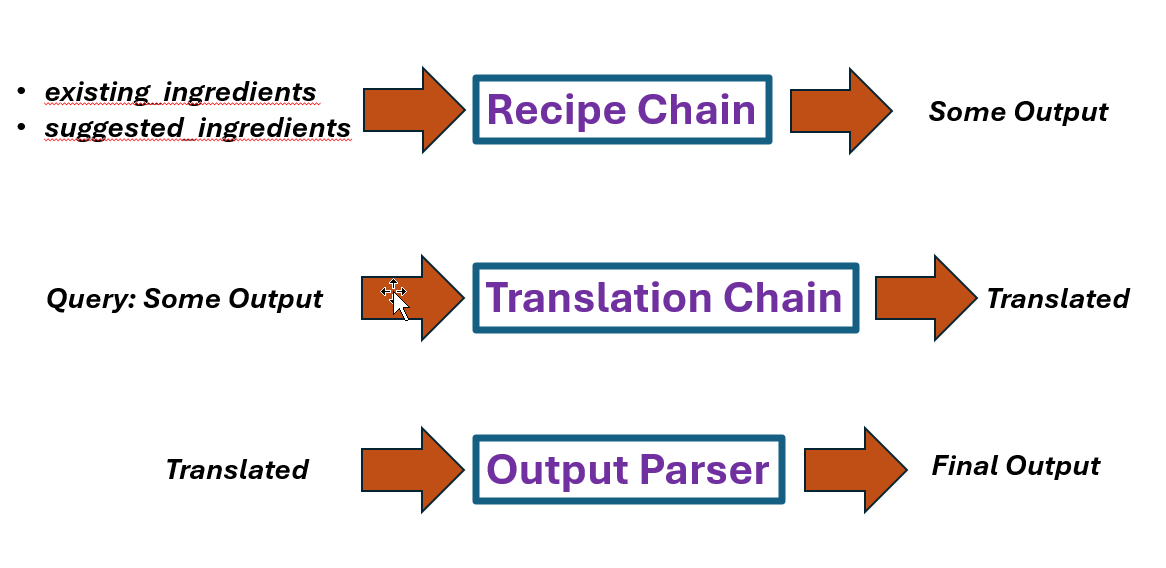

In [68]:
Image(filename= "tutorial/LLM+Langchain/Week-2/LCEL_1.png")

## Minimal Example

### 1. Creating a Prompt Template (創建提示模板):

- ChatPromptTemplate.from_template is used to create a prompt template. This template is a string that includes a placeholder {topic}.
- The template specifies the instruction: "tell me a short joke about {topic}".
- 使用 ChatPromptTemplate.from_template 創建一個提示模板。這個模板是一個包含佔位符 {topic} 的字符串。
- 模板指定了指令：“tell me a short joke about {topic}”（給我講一個關於{topic}的簡短笑話）。

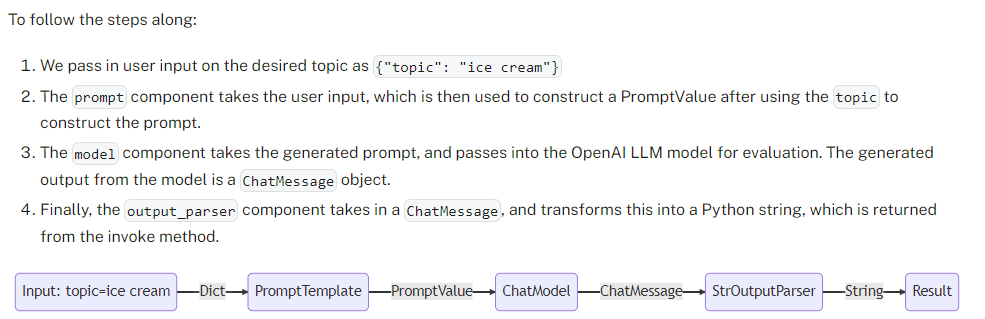

In [69]:
## Official diagram flow

Image(filename= "tutorial/LLM+Langchain/Week-2/lcel pipeline.png")

In [70]:
prompt = ChatPromptTemplate.from_template("tell me a short joke about {topic}")
# prompt = ChatPromptTemplate(template="tell me a short joke about {topic}")

In [71]:
prompt

ChatPromptTemplate(input_variables=['topic'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['topic'], input_types={}, partial_variables={}, template='tell me a short joke about {topic}'), additional_kwargs={})])

### 2. Setting Up the Chain (設置鏈條):

- chain = prompt | model sets up a chain where the prompt is connected to a model. This means that the model will process the prompt to generate a response.
- The | operator is used to combine the prompt and the model into a single chain.
- chain = prompt | model 設置了一個鏈條，其中提示連接到模型。這意味著模型將處理該提示來生成回應。
- | 運算符用於將提示和模型組合成一個鏈條。

In [72]:
# from the PromptTemplate to the ChatModel

pipeline_ = prompt | model

### 3. Getting the Joke (獲取笑話):

- The result of chain.invoke({"topic": "ice cream"}) is stored in the variable joke.
- This variable now contains the generated joke about ice cream.
- chain.invoke({"topic": "ice cream"}) 的結果存儲在變量 joke 中。
- 這個變量現在包含生成的關於冰淇淋的笑話。

In [73]:
# input -> prompt template -> model

joke = pipeline_.invoke({"topic": "ice cream"})

In [74]:
joke

AIMessage(content='Why did the ice cream cone break up with the sundae? \n\nBecause it found someone cooler!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 15, 'total_tokens': 35, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BlhRxqxP7lwhQj7hIJbnyTf3GjF1a', 'finish_reason': 'stop', 'logprobs': None}, id='run--878e313e-2729-4da2-aa2b-5146b93b91de-0', usage_metadata={'input_tokens': 15, 'output_tokens': 20, 'total_tokens': 35, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [75]:
print(joke.content)

Why did the ice cream cone break up with the sundae? 

Because it found someone cooler!


### 1. Importing StrOutputParser (導入 StrOutputParser):

- The code imports StrOutputParser from the langchain_core.output_parsers module. This class is used to parse the output of the model into a string format.
- 代碼從 langchain_core.output_parsers 模塊導入 StrOutputParser。這個類用於將模型的輸出解析為字符串格式。

### 2. Creating an Output Parser:

- An instance of StrOutputParser is created and assigned to the variable output_parser.
- This parser will be used to process the raw output from the model and convert it into a readable string format.
- 創建一個 StrOutputParser 的實例，並將其賦值給變量 output_parser。
- 這個解析器將用於處理來自模型的原始輸出，並將其轉換為可讀的字符串格式。

In [76]:
from langchain_core.output_parsers import StrOutputParser

output_parser = StrOutputParser()

pipeline_ = prompt | model | output_parser

# input -> prompt template -> model -> output parser

pipeline_.invoke({"topic": "ice cream"})

'Why did the ice cream cone break up with the sundae? \n\nBecause it found someone cooler!'

## 範例操作

### Coercion

Do not ask me why this word is used....

In [ ]:
Image(filename= "tutorial/LLM+Langchain/Week-2/LCEL_2.png")

In [ ]:
joke_chain = prompt | model | output_parser

template = """
           is this a funny joke? {joke}
           """

human_prompt = PromptTemplate(template=template,
                              input_variables=['joke'])

human_message = HumanMessagePromptTemplate(prompt=human_prompt)

analysis_prompt = ChatPromptTemplate(messages=[human_message])

analysis_chain = analysis_prompt | model

"""
1. 
joke = joke_chain.invoke({"topic": "ice cream"})
2.
analysis_chain.invoke({"joke": joke})
"""

composed_chain = {"joke": joke_chain} | analysis_chain | output_parser

In [ ]:
print(composed_chain.invoke({"topic": "ice cream"}))

1. chain 執行結果，將結果放進'joke' 這個 key 裡
2. {"joke": content} 被送進analysis_prompt 中，等價於 analysis_prompt.invoke({"joke": content})
3. model 接收 analysis_prompt 產生的結果
4. output_parser 處理結果

In [ ]:
template = "Translate:\n\n{query}\n\ninto traditional Chinese"

human_prompt = PromptTemplate(template=template,
                              input_variables=['query'])

human_message = HumanMessagePromptTemplate(prompt=human_prompt)

translation_prompt = ChatPromptTemplate(messages=[human_message])

translation_chain = translation_prompt | model

e2e_pipeline = {"query": composed_chain}|translation_chain|output_parser
e2e_pipeline.invoke({"topic": "ice cream"})

## Parallelize steps

In [ ]:
from langchain_core.runnables import RunnableParallel

joke_chain = ChatPromptTemplate.from_template("tell me a joke about {topic}") | model
poem_chain = ChatPromptTemplate.from_template("write a 2-line poem about {topic}") | model

map_chain = RunnableParallel(joke=joke_chain, poem=poem_chain)

map_chain.invoke({"topic": "bear"})

- Computation time

In [ ]:
%%timeit

joke_chain.invoke({"topic": "bear"})

In [ ]:
%%timeit

poem_chain.invoke({"topic": "bear"})

In [ ]:
%%timeit

map_chain.invoke({"topic": "bear"})

RunnableParallel are also useful for running independent processes in parallel, since each Runnable in the map is executed in parallel. For example, we can see our earlier joke_chain, poem_chain and map_chain all have about the same runtime, even though map_chain executes both of the other two.



## Run custom function

In [ ]:
from operator import itemgetter

from langchain_core.runnables import RunnableLambda


def length_function(text):
    return len(text)


def _multiple_length_function(text1, text2):
    return len(text1) * len(text2)


def multiple_length_function(_dict):
    return _multiple_length_function(_dict["text1"], _dict["text2"])

prompt = ChatPromptTemplate.from_template("what is {a} + {b}")

pipeline_ = (
    {
        "a": itemgetter("foo") | length_function,
        "b": {"text1": itemgetter("foo"), "text2": itemgetter("bar")}
        | multiple_length_function,
    }
    | prompt
    | model
)

- Oops, how to solve this error message? 

In [ ]:
# wrap the function with RunnableLambda

pipeline_ = (
    {
        "a": itemgetter("foo") | RunnableLambda(length_function),
        "b": {"text1": itemgetter("foo"), "text2": itemgetter("bar")}
        | RunnableLambda(multiple_length_function),
    }
    | prompt
    | model
)


In [ ]:
pipeline_.invoke({"foo": "bar", "bar": "gah"})

How does it work?

- 'bar' -> foo, foo ('bar') -> length_function => a = 3
- 'bar' -> foo & 'gah' -> bar, foo ('bar') -> 'text1' & bar ('gah') -> 'text2', {'text1': 'bar', 'text2': 'gah'} -> multiple_length_function => b = 9
- {'a':3, 'b': 9} -> prompt -> 'what is 3 + 9'

#### Decorator

- A very cool feature.
- This was a new discovery at the beginning of December, so it is not used in subsequent tutorials. However, feel free to adapt the code and experience its magic.
- Understanding programming remains key to building successful AI applications.

In [ ]:
from operator import itemgetter
from langchain_core.runnables import chain, RunnableParallel

prompt = ChatPromptTemplate.from_template("what is {a} + {b}")

@chain
def length_function(text):
    return len(text)

def _multiple_length_function(text1, text2):
    return len(text1) * len(text2)

@chain
def multiple_length_function(_dict):
    return _multiple_length_function(_dict["text1"], _dict["text2"])

pipeline_ = RunnableParallel(
        a=itemgetter("foo") | length_function,
        b={"text1": itemgetter("foo"), "text2": itemgetter("bar")}
        | multiple_length_function)| prompt | model

pipeline_.invoke({"foo": "bar", "bar": "gah"})

## Passing data through

In [ ]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

runnable = RunnableParallel(
    passed=RunnablePassthrough(),
    modified=lambda x: x["num"] + 1,
)

runnable.invoke({"num": 1})

In [ ]:
runnable = RunnableParallel(
    passed=RunnablePassthrough(),
    modified=itemgetter("num"),
)

runnable.invoke({"num": 1})

In [ ]:
runnable = RunnableParallel(
    passed_2=RunnablePassthrough(),
    modified=lambda x: x["num"] + 1,
)

runnable.invoke({"num": 5})

## RAG + LCEL

In [ ]:
@chain
def chatbot_prompt_fn(data):

    system_template = """
                      You are a helpful assistant. Answer all questions to the best of your ability.
                      """
    
    human_template = """
                     question: {question}

                     Please answer the question based on the context:
                     {context}
                     """
    
    input_ = {"system": {"template": system_template},
              "human": {"template": human_template,
                        "input_variable": ["question", "context"]}}
    
    prompt_template = build_standard_chat_prompt_template(input_)
    
    return prompt_template


embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

path = os.path.join(get_project_dir(), 'tutorial', 'LLM+Langchain', 'Week-2', 'BertV2 Index')

vectorstore = FAISS.load_local(path, embeddings, allow_dangerous_deserialization=True)

retriever = vectorstore.as_retriever(search_type="similarity", 
                                     search_kwargs={"k": 5})

pipeline_ = RunnablePassthrough.assign(context=itemgetter('question')|retriever)
pipeline_.invoke({"question": "Is it difficult to fine-tune BERT?"})

In [ ]:
pipeline_ = RunnablePassthrough.assign(context=itemgetter('question')|retriever)|chatbot_prompt_fn|model|StrOutputParser()

In [ ]:
pipeline_.invoke({"question": "Is it difficult to fine-tune BERT?"})

## Translation Template

In [ ]:
from langchain_core.runnables import chain

@chain
def translation_function(text):

    """
    翻譯
    直接將給予內容text翻譯成繁體中文
    """
    
    system_template = """
                      You are a helpful AI assistant with native speaker 
                      fluency in both English and traditional Chinese 
                      (繁體中文). You will translate the given content into traditional Chinese 
                      (繁體中文).
                      """

    human_template = """
                     {query}
                     """

    input_ = {"system": {"template": system_template},
              "human": {"template": human_template,
                        "input_variable": ["query"]}}
    
    prompt_template = build_standard_chat_prompt_template(input_)

    return prompt_template

In [ ]:
step_1 = RunnablePassthrough.assign(context=itemgetter('question')|retriever)

step_2 = step_1|chatbot_prompt_fn|model|StrOutputParser()

In [ ]:
pipeline_ = {"query": step_2}|translation_function|model|StrOutputParser()

In [ ]:
pipeline_.invoke({"question": "Is it difficult to fine-tune BERT?"})

## Coding with LLM

Experience phase

In [ ]:
from langchain_core.output_parsers import StrOutputParser


# I created this last week after the session
def build_standard_chat_prompt_template(kwargs):

    system_content = kwargs['system']
    human_content = kwargs['human']
    
    system_prompt = PromptTemplate(**system_content)
    system_message = SystemMessagePromptTemplate(prompt=system_prompt)
    
    human_prompt = PromptTemplate(**human_content)
    human_message = HumanMessagePromptTemplate(prompt=human_prompt)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message,
                                                     human_message
                                                   ])

    return chat_prompt


system_template = (
    "You are a highly skilled Python developer. Your task is to generate Python code strictly based on the user's instructions.\n"
    "Leverage statistical and mathematical libraries such as `statsmodels`, `scipy`, and `numpy` where appropriate to solve the problem.\n"
    "Your response must contain only the Python code — no explanations, comments, or additional text.\n\n"
    "Code:"
)

human_template = '{query}'


input_ = {"system": {"template": system_template},
          "human": {"template": human_template,
                    "input_variable": ["query"]}}

chat_prompt = build_standard_chat_prompt_template(input_)

code_pipeline = chat_prompt|model|StrOutputParser()

In [ ]:
code = code_pipeline.invoke({"query": "Calculate the area of a circile with radius 3.8976"})

In [ ]:
print(code)

In [ ]:
import re

match = re.findall(r"python\n(.*?)\n```", code, re.DOTALL)
python_code = match[0]

exec(python_code)

It can run. But how to extract the result generated from the code?

### ✅ `exec(...)`

- `exec()` runs the code you give it **as if it was a Python script**.
- It does **not return values**; it just executes statements (like `import`, assignments, function definitions, etc.).

---

### ✅ `{}` — the *global namespace*

- An **empty dictionary** is passed as the *global namespace*.
- This isolates the execution from your actual global scope, which is **good for sandboxing** and avoiding side effects.

---

### ✅ `local_vars` — the *local namespace*

- This dictionary collects all **local variables** defined during execution.
- After the code runs, `local_vars` will contain all the variables and their values.

```python
{
  'np': <module 'numpy'...>,
  'radius': 3.8976,
  'area': 47.73155744152567
}

In [ ]:
python_code

In [ ]:
lines = python_code.strip().split('\n')
*stmts, last_line = lines

In [ ]:
lines

In [ ]:
local_vars = {}
exec('\n'.join(stmts), {}, local_vars)

In [ ]:
local_vars

In [ ]:
import math

math.pi * 3.8976 * 3.8976

What if we calculate the area without the code part?

In [ ]:
model.invoke("Calculate the area of a circile with radius 3.8976")

### Combine the code generation and code execution in LCEL

In [ ]:
from langchain_core.runnables import chain


@chain
def code_execution(code):

    match = re.findall(r"python\n(.*?)\n```", code, re.DOTALL)
    python_code = match[0]
    
    lines = python_code.strip().split('\n')
    *stmts, last_line = lines

    local_vars = {}
    exec('\n'.join(stmts), {}, local_vars)

    return local_vars


code_pipeline = chat_prompt|model|StrOutputParser()|code_execution

In [ ]:
17 * 33

In [ ]:
17 * 7

In [ ]:
code_pipeline.invoke("What is the GCD of 561 and 119?")

In [ ]:
model.invoke("What is the GCD of 561 and 119?")

In [ ]:
code_pipeline.invoke("What is the area of a triangle, with two sides with length 10 and 5, and the angle between them is 35 degrees?")

In [ ]:
import numpy

5 * 10 * np.sin(35/180 * math.pi) / 2

In [ ]:
answer = code_pipeline.invoke("What is the area of a triangle, with two sides with length 10 and 5, and the angle between them is 35 degrees?")

In [ ]:
answer

In [ ]:
def build_standard_chat_prompt_template(kwargs):

    system_content = kwargs.get('system')
    human_content = kwargs['human']

    if system_content:
        system_prompt = PromptTemplate(**system_content)
        system_message = SystemMessagePromptTemplate(prompt=system_prompt)
    
    human_prompt = PromptTemplate(**human_content)
    human_message = HumanMessagePromptTemplate(prompt=human_prompt)

    if system_content:
        chat_prompt = ChatPromptTemplate.from_messages([system_message,
                                                         human_message
                                                       ])
    else:
        chat_prompt = ChatPromptTemplate.from_messages([human_message])
    
    return chat_prompt


input_ = {"human": {"template": "{task}:\n{answer}",
                    "input_variable": ["task", 'answer']}}

extraction_prompt = build_standard_chat_prompt_template(input_)

extraction_pipeline = extraction_prompt|model

In [ ]:
extraction_pipeline.invoke({"task": "What is the area of a triangle, with two sides with length 10 and 5, and the angle between them is 35 degrees?",
                            "answer": answer})

In [ ]:
class Output(BaseModel):

    name: float = Field(description="The answer to the question. ")

output_parser = PydanticOutputParser(pydantic_object=Output)
format_instructions = output_parser.get_format_instructions()


input_ = {"human": {"template": "{task}:\n{answer}\n\nOutput format instruction: {format_instructions}",
                    "input_variable": ["task", 'answer'],
                    "partial_variables": {"format_instructions": 
                                          format_instructions}}}

extraction_prompt = build_standard_chat_prompt_template(input_)

extraction_pipeline = extraction_prompt|model|output_parser

final_answer = extraction_pipeline.invoke({"task": "What is the area of a triangle, with two sides with length 10 and 5, and the angle between them is 35 degrees?",
                                           "answer": answer})

In [ ]:
final_answer